In [1]:
__author__ = "Arkadiusz Wos"
__copyright__ = "Arkadiusz Wos"
__version__ = "1.0 20.05.2018"
__email__ = "arkadiusz.wos@gmail.com"

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import boxcox

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.pyplot import figure
from matplotlib.legend_handler import HandlerLine2D

from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.utils import resample
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics, cross_validation
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score



import xgboost as xgb
from xgboost import XGBClassifier

from ml_metrics import rmsle


#to print multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
#Read the file
csv_file = r'C:\Users\Arkadiusz Wos\Desktop\!Podyplomowe!\DF_7days.csv'
df = pd.read_csv(csv_file)
df.drop(columns=['userid', 'dbs'], inplace = True)
df.head()

,high_roller_mark,gw_7_days,egw_7_days,bet_7_days,number_of_bets_7_days,number_of_games_7_days
0,1,285.9912,222.909660,6709.8827,4887,6
1,1,9549.9449,3965.716762,107181.5341,2331,1
2,1,4616.7053,925.978947,28936.8421,4342,2
3,1,6886.0000,1516.700000,40612.5000,600,3
4,1,8.6000,0.549900,14.1000,26,1


### Data description

In [4]:
#before
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2410010 entries, 0 to 2410009
Data columns (total 6 columns):
high_roller_mark          int64
gw_7_days                 float64
egw_7_days                float64
bet_7_days                float64
number_of_bets_7_days     int64
number_of_games_7_days    int64
dtypes: float64(3), int64(3)
memory usage: 110.3 MB


In [5]:
#number of high rollers
df['high_roller_mark'].value_counts()

0    2408392
1       1618
Name: high_roller_mark, dtype: int64

In [6]:
#check nulls
np.any(np.isnan(df))

False

In [7]:
df.min()
df.max()

high_roller_mark               0.000000
gw_7_days                -136350.330000
egw_7_days                     0.000179
bet_7_days                     0.004700
number_of_bets_7_days          1.000000
number_of_games_7_days         1.000000
dtype: float64

high_roller_mark          1.000000e+00
gw_7_days                 9.938020e+04
egw_7_days                7.646464e+04
bet_7_days                2.061981e+06
number_of_bets_7_days     1.601670e+05
number_of_games_7_days    5.600000e+01
dtype: float64

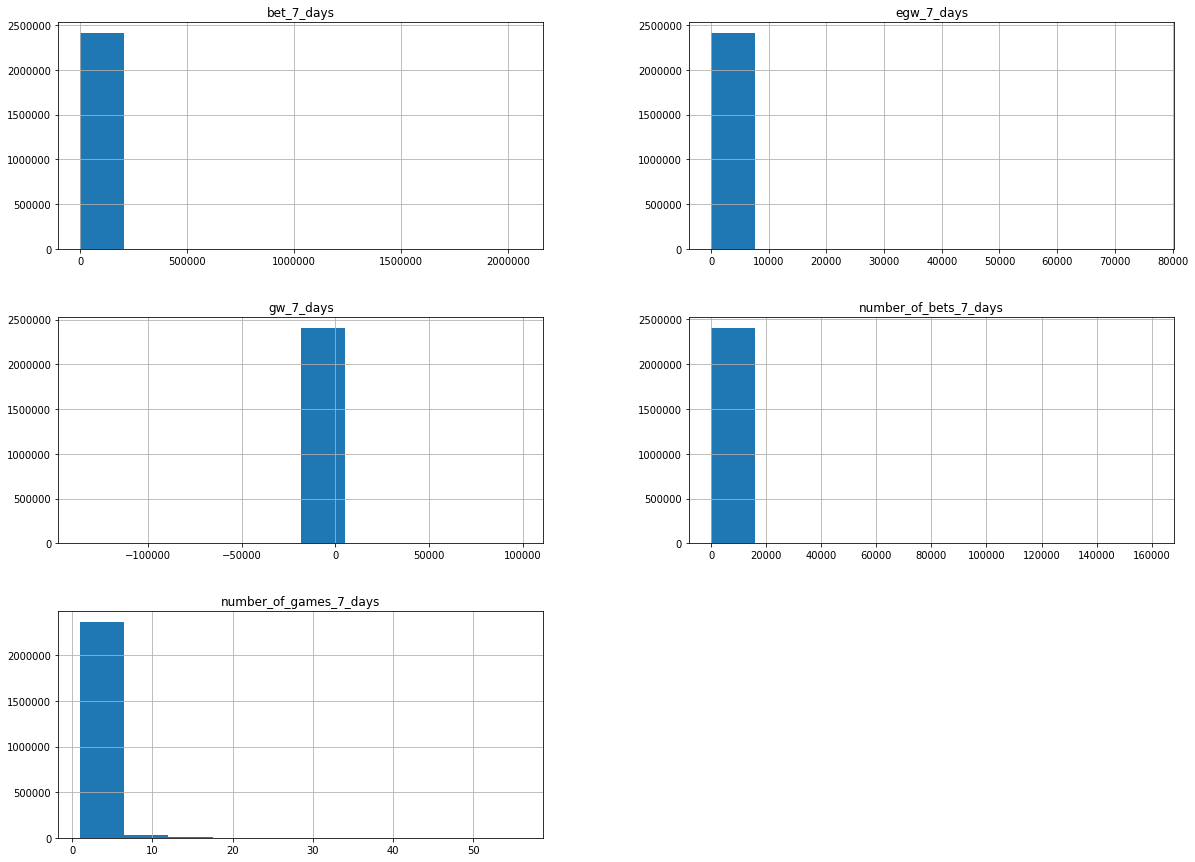

In [8]:
#histogram befoore feature engineereig
df[['gw_7_days','egw_7_days','bet_7_days','number_of_bets_7_days','number_of_games_7_days']].hist(bins = 10, figsize = (20,15));

## Pre-processing data

### Balancing data

In [9]:
df_majority = df[df['high_roller_mark']==0]
df_minority = df[df['high_roller_mark']==1]

In [10]:
#up-sample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=10000,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 


# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=100000,     # to match minority class
                                 random_state=123) # reproducible results

# Display new class counts
balanced_df = pd.concat([df_majority_downsampled, df_minority_upsampled])
balanced_df['high_roller_mark'].value_counts()

0    100000
1     10000
Name: high_roller_mark, dtype: int64

### Transformation to normal distribution

In [11]:
transformet_df = df[['gw_7_days','egw_7_days','bet_7_days','number_of_bets_7_days','number_of_games_7_days','high_roller_mark']]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002AF836FC898>,
      dtype=object)

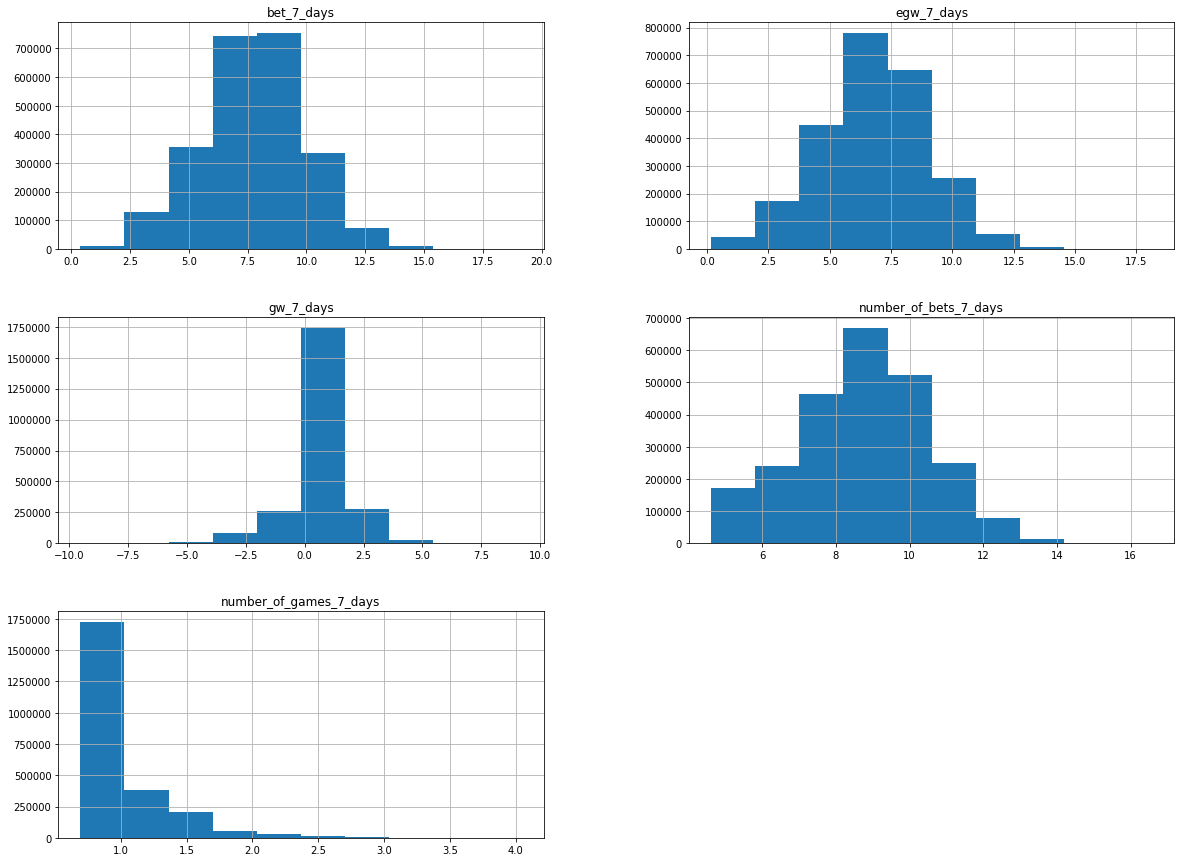

In [12]:
transformet_df['gw_7_days'] = transformet_df['gw_7_days'].apply(lambda x:np.sign(x)*(np.log(abs(x)+ 10) - np.log(10)))
transformet_df['egw_7_days'] = transformet_df['egw_7_days'].apply(lambda x:np.sign(x)*(np.log(abs(x)+ 0.001) - np.log(0.001)))
transformet_df['bet_7_days'] = transformet_df['bet_7_days'].apply(lambda x:np.sign(x)*(np.log(abs(x)+ 0.01) - np.log(0.01)))
transformet_df['number_of_bets_7_days'] = transformet_df['number_of_bets_7_days'].apply(lambda x:np.sign(x)*(np.log(abs(x)+ 0.01) - np.log(0.01)))
transformet_df['number_of_games_7_days'] = transformet_df['number_of_games_7_days'].apply(lambda x:np.sign(x)*(np.log(abs(x)+ 1) - np.log(1)))
transformet_df[['gw_7_days','egw_7_days','bet_7_days','number_of_bets_7_days','number_of_games_7_days']].hist(bins = 10, figsize = (20,15))


### Normalization

In [13]:
min_max_scaler = preprocessing.MinMaxScaler()

#change type to float
float_array = transformet_df[['gw_7_days','egw_7_days','bet_7_days','number_of_bets_7_days','number_of_games_7_days']].values.astype(float)
scaled_array = min_max_scaler.fit_transform(float_array)
np.min(scaled_array), np.max(scaled_array)

(0.0, 1.0)

In [14]:
#create data frame for normalized data
scaled_df = pd.DataFrame(data=scaled_array)
scaled_df.columns = ['gw_7_days','egw_7_days','bet_7_days','number_of_bets_7_days','number_of_games_7_days']

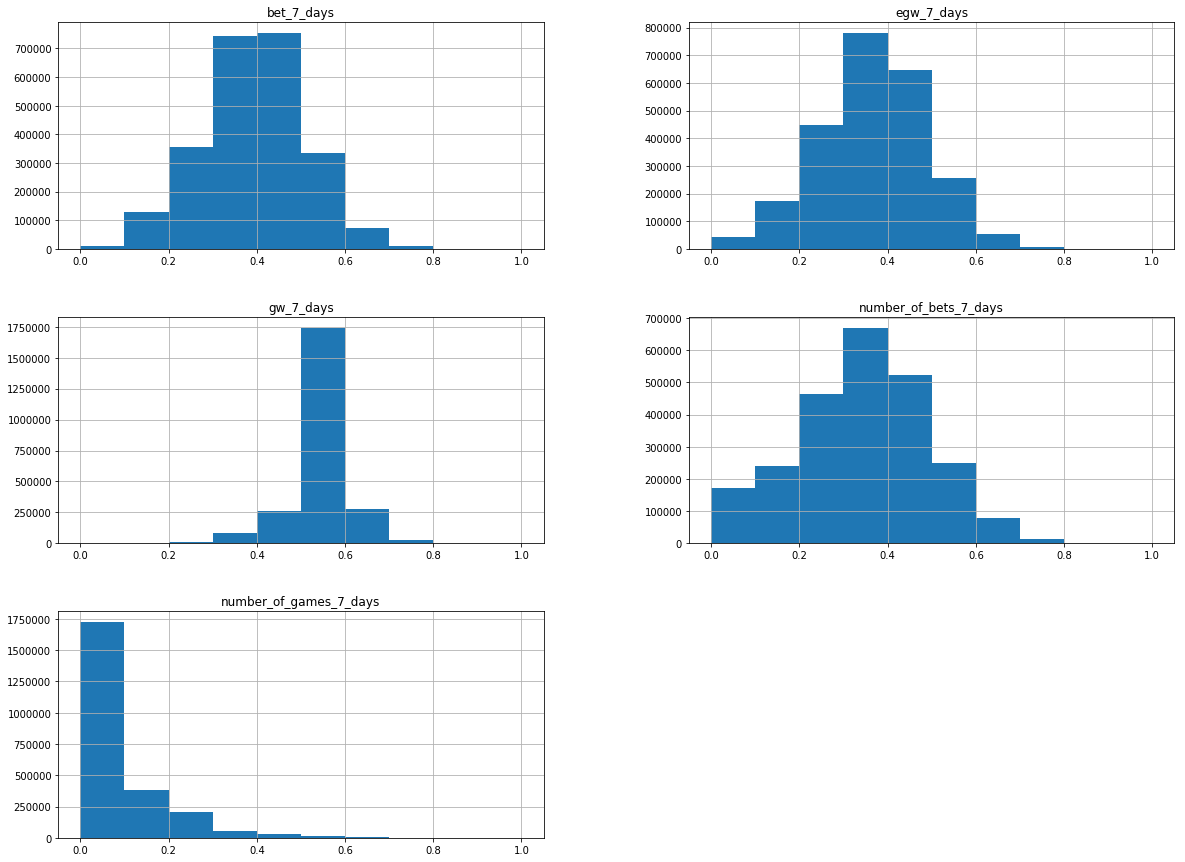

In [15]:
scaled_df.hist(bins = 10, figsize = (20,15));

# Machine learning algorithms

## Logistic Regretion

### Raw data

In [17]:
y_raw = df['high_roller_mark']
X_raw = df[['gw_7_days','egw_7_days','bet_7_days','number_of_bets_7_days','number_of_games_7_days']]

x_train, x_test, y_train, y_test = train_test_split( X_raw, y_raw, test_size=0.3, random_state=0)
model = LogisticRegression().fit(x_train, y_train) 
y_pred=model.predict(x_test)

print("Confusion matrix below:")
confusion_matrix(y_test, y_pred, labels=[1,0])

print('Accurancy: {0:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_pred)))

Confusion matrix below:


array([[   106,    365],
       [    67, 722465]], dtype=int64)

Accurancy: 1.00
Precision: 0.61
Recall: 0.23


In [18]:
unique, counts = np.unique(y_pred, return_counts=True)
print("Number of predicted labels")
print(np.asarray((unique, counts)))

Number of predicted labels
[[     0      1]
 [722830    173]]


In [19]:
#checking stability on train dataset
y_pred=model.predict(x_train)
print("Confusion matrix train below:")

print('Accurancy: {0:.2f}'.format(accuracy_score(y_train, y_pred)))
print('Precision: {0:.2f}'.format(precision_score(y_train, y_pred)))
print('Recall: {0:.2f}'.format(recall_score(y_train, y_pred)))

Confusion matrix train below:
Accurancy: 1.00
Precision: 0.64
Recall: 0.23


### Normalized data

In [20]:
y_raw = df['high_roller_mark']
X_raw = scaled_df[['gw_7_days','egw_7_days','bet_7_days','number_of_bets_7_days','number_of_games_7_days']]

x_train, x_test, y_train, y_test = train_test_split( X_raw, y_raw, test_size=0.3, random_state=0)
model = LogisticRegression().fit(x_train, y_train) 

y_pred=model.predict(x_test)


print("Confusion matrix below:")
confusion_matrix(y_test, y_pred, labels=[1,0])

print('Accurancy: {0:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_pred)))

Confusion matrix below:


array([[    44,    427],
       [     9, 722523]], dtype=int64)

Accurancy: 1.00
Precision: 0.83
Recall: 0.09


In [21]:
unique, counts = np.unique(y_pred, return_counts=True)
print("Number of predicted labels:")
print(np.asarray((unique, counts)))

Number of predicted labels:
[[     0      1]
 [722950     53]]


In [22]:
#checking stability on train dataset
y_pred=model.predict(x_train)
print("Confusion matrix train below:")

print('Accurancy: {0:.2f}'.format(accuracy_score(y_train, y_pred)))
print('Precision: {0:.2f}'.format(precision_score(y_train, y_pred)))
print('Recall: {0:.2f}'.format(recall_score(y_train, y_pred)))

Confusion matrix train below:
Accurancy: 1.00
Precision: 0.81
Recall: 0.10


### Transformed data

In [23]:
y_raw = transformet_df['high_roller_mark']
X_raw = transformet_df[['gw_7_days','egw_7_days','bet_7_days','number_of_bets_7_days','number_of_games_7_days']]

x_train, x_test, y_train, y_test = train_test_split( X_raw, y_raw, test_size=0.3, random_state=0)
model = LogisticRegression().fit(x_train, y_train) 
y_pred=model.predict(x_test)


print("Confusion matrix below:")
confusion_matrix(y_test, y_pred, labels=[1,0])

print('Accurancy: {0:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_pred)))

Confusion matrix below:


array([[    63,    408],
       [    19, 722513]], dtype=int64)

Accurancy: 1.00
Precision: 0.77
Recall: 0.13


In [24]:
unique, counts = np.unique(y_pred, return_counts=True)
print("Number of predicted labels:")
print(np.asarray((unique, counts)))

Number of predicted labels:
[[     0      1]
 [722921     82]]


In [25]:
#checking stability on train dataset
y_pred=model.predict(x_train)
print("Confusion matrix train below:")

print('Accurancy: {0:.2f}'.format(accuracy_score(y_train, y_pred)))
print('Precision: {0:.2f}'.format(precision_score(y_train, y_pred)))
print('Recall: {0:.2f}'.format(recall_score(y_train, y_pred)))

Confusion matrix train below:
Accurancy: 1.00
Precision: 0.71
Recall: 0.14


### Balanced data

In [61]:
y_raw = balanced_df['high_roller_mark']
X_raw = balanced_df[['gw_7_days','egw_7_days','bet_7_days','number_of_bets_7_days','number_of_games_7_days']]

x_train, x_test, y_train, y_test = train_test_split( X_raw, y_raw, test_size=0.3, random_state=0)
model = LogisticRegression().fit(x_train, y_train) 
y_pred=model.predict(x_test)


print("Confusion matrix below:")
confusion_matrix(y_test, y_pred, labels=[1,0])

print('Accurancy: {0:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_pred)))

Confusion matrix below:


array([[ 1922,  1037],
       [  141, 29900]], dtype=int64)

Accurancy: 0.96
Precision: 0.93
Recall: 0.65


In [62]:
unique, counts = np.unique(y_pred, return_counts=True)
print("Number of predicted labels:")
print(np.asarray((unique, counts)))

Number of predicted labels:
[[    0     1]
 [30937  2063]]


In [63]:
#again the same but without creating model!
y_raw = df['high_roller_mark']
X_raw = df[['gw_7_days','egw_7_days','bet_7_days','number_of_bets_7_days','number_of_games_7_days']]
x_train, x_test, y_train, y_test = train_test_split( X_raw, y_raw, test_size=0.3, random_state=0)

y_pred=model.predict(x_test)

print("Confusion matrix below:")
confusion_matrix(y_test, y_pred, labels=[1,0])

print('Accurancy: {0:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_pred)))

Confusion matrix below:


array([[   288,    183],
       [  3132, 719400]], dtype=int64)

Accurancy: 1.00
Precision: 0.08
Recall: 0.61


In [30]:
unique, counts = np.unique(y_pred, return_counts=True)
print("Number of predicted labels:")
print(np.asarray((unique, counts)))

Number of predicted labels:
[[     0      1]
 [719583   3420]]


In [64]:
#checking stability on train dataset
y_pred=model.predict(x_train)
print("Confusion matrix train below:")

print('Accurancy: {0:.2f}'.format(accuracy_score(y_train, y_pred)))
print('Precision: {0:.2f}'.format(precision_score(y_train, y_pred)))
print('Recall: {0:.2f}'.format(recall_score(y_train, y_pred)))

Confusion matrix train below:
Accurancy: 1.00
Precision: 0.09
Recall: 0.66


## Random Forest

### Looking the best number of estimators

Text(0,0.5,'AUC score')

Text(0.5,0,'n_estimators')

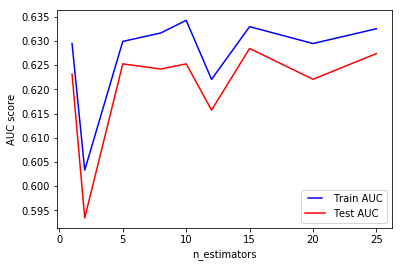

In [41]:
y_raw = df['high_roller_mark']
X_raw = df[['gw_7_days','egw_7_days','bet_7_days','number_of_bets_7_days','number_of_games_7_days']]
x_train, x_test, y_train, y_test = train_test_split( X_raw, y_raw, test_size=0.3, random_state=0)


n_estimators = [1, 2, 5, 8, 10, 12, 15, 20, 25]
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, max_depth = 3, n_jobs=-1)
    rf = rf.fit(x_train, y_train)
    train_pred = rf.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

### Looking the best max depth

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

Text(0,0.5,'AUC score')

Text(0.5,0,'Tree depth')

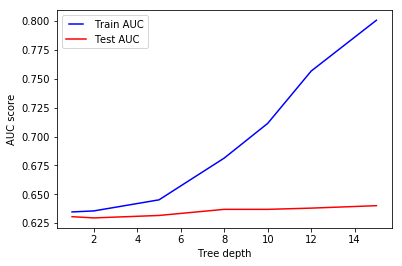

In [40]:
y_raw = df['high_roller_mark']
X_raw = df[['gw_7_days','egw_7_days','bet_7_days','number_of_bets_7_days','number_of_games_7_days']]
x_train, x_test, y_train, y_test = train_test_split( X_raw, y_raw, test_size=0.3, random_state=0)


#max_depths = np.linspace(1, 32, 32, endpoint = True) dosen't work for XGBoost
max_depths = [1, 2, 5, 8, 10, 12, 15]

train_results = []
test_results = []
for max_depth in max_depths:
    rf = XGBClassifier(max_depth=max_depth, n_jobs=-1)
    rf=rf.fit(x_train, y_train)
    train_pred = rf.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

### Raw data

In [42]:
y_raw = df['high_roller_mark']
X_raw = df[['gw_7_days','egw_7_days','bet_7_days','number_of_bets_7_days','number_of_games_7_days']]
x_train, x_test, y_train, y_test = train_test_split( X_raw, y_raw, test_size=0.3, random_state=0)


model = RandomForestClassifier(max_depth = 3, n_estimators = 5).fit(x_train, y_train) 

print("Confusion matrix below:")
confusion_matrix(y_test, y_pred, labels=[1,0])

print('Accurancy: {0:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_pred)))

Confusion matrix below:


array([[   120,    351],
       [     7, 722525]], dtype=int64)

Accurancy: 1.00
Precision: 0.94
Recall: 0.25


In [43]:
unique, counts = np.unique(y_pred, return_counts=True)
print("Number of predicted labels:")
print(np.asarray((unique, counts)))

Number of predicted labels:
[[     0      1]
 [722876    127]]


In [44]:
#checking stability on train dataset
y_pred=model.predict(x_train)
print("Confusion matrix train below:")

print('Accurancy: {0:.2f}'.format(accuracy_score(y_train, y_pred)))
print('Precision: {0:.2f}'.format(precision_score(y_train, y_pred)))
print('Recall: {0:.2f}'.format(recall_score(y_train, y_pred)))

Confusion matrix train below:
Accurancy: 1.00
Precision: 0.97
Recall: 0.27


### Normalized data

In [45]:
y_raw = df['high_roller_mark']
X_raw = scaled_df[['gw_7_days','egw_7_days','bet_7_days','number_of_bets_7_days','number_of_games_7_days']]
x_train, x_test, y_train, y_test = train_test_split( X_raw, y_raw, test_size=0.3, random_state=0)


model = RandomForestClassifier(max_depth = 3, n_estimators = 5).fit(x_train, y_train) 
y_pred=model.predict(x_test)

print("Confusion matrix below:")
confusion_matrix(y_test, y_pred, labels=[1,0])

print('Accurancy: {0:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_pred)))

Confusion matrix below:


array([[   118,    353],
       [     8, 722524]], dtype=int64)

Accurancy: 1.00
Precision: 0.94
Recall: 0.25


In [46]:
unique, counts = np.unique(y_pred, return_counts=True)
print("Number of predicted labels:")
print(np.asarray((unique, counts)))

Number of predicted labels:
[[     0      1]
 [722877    126]]


In [47]:
#checking stability on train dataset
y_pred=model.predict(x_train)
print("Confusion matrix train below:")

print('Accurancy: {0:.2f}'.format(accuracy_score(y_train, y_pred)))
print('Precision: {0:.2f}'.format(precision_score(y_train, y_pred)))
print('Recall: {0:.2f}'.format(recall_score(y_train, y_pred)))

Confusion matrix train below:
Accurancy: 1.00
Precision: 0.94
Recall: 0.26


### Transformed data

In [52]:
y_raw = transformet_df['high_roller_mark']
X_raw = transformet_df[['gw_7_days','egw_7_days','bet_7_days','number_of_bets_7_days','number_of_games_7_days']]
x_train, x_test, y_train, y_test = train_test_split( X_raw, y_raw, test_size=0.3, random_state=0)


model = RandomForestClassifier(max_depth = 3, n_estimators = 5).fit(x_train, y_train) 
y_pred=model.predict(x_test)

print("Confusion matrix below:")
confusion_matrix(y_test, y_pred, labels=[1,0])

print('Accurancy: {0:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_pred)))

Confusion matrix below:


array([[   109,    362],
       [     7, 722525]], dtype=int64)

Accurancy: 1.00
Precision: 0.94
Recall: 0.23


In [53]:
unique, counts = np.unique(y_pred, return_counts=True)
print("Number of predicted labels:")
print(np.asarray((unique, counts)))

Number of predicted labels:
[[     0      1]
 [722887    116]]


In [54]:
#checking stability on train dataset
y_pred=model.predict(x_train)
print("Confusion matrix train below:")

print('Accurancy: {0:.2f}'.format(accuracy_score(y_train, y_pred)))
print('Precision: {0:.2f}'.format(precision_score(y_train, y_pred)))
print('Recall: {0:.2f}'.format(recall_score(y_train, y_pred)))

Confusion matrix train below:
Accurancy: 1.00
Precision: 0.97
Recall: 0.26


### Balanced data

In [55]:
y_raw = balanced_df['high_roller_mark']
X_raw = balanced_df[['gw_7_days','egw_7_days','bet_7_days','number_of_bets_7_days','number_of_games_7_days']]
x_train, x_test, y_train, y_test = train_test_split( X_raw, y_raw, test_size=0.3, random_state=0)

model = RandomForestClassifier(max_depth = 3, n_estimators = 5).fit(x_train, y_train) 
y_pred=model.predict(x_test)


print("Confusion matrix below:")
confusion_matrix(y_test, y_pred, labels=[1,0])

print('Accurancy: {0:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_pred)))

Confusion matrix below:


array([[ 2146,   813],
       [  227, 29814]], dtype=int64)

Accurancy: 0.97
Precision: 0.90
Recall: 0.73


In [56]:
unique, counts = np.unique(y_pred, return_counts=True)
print("Number of predicted labels:")
print(np.asarray((unique, counts)))

Number of predicted labels:
[[    0     1]
 [30627  2373]]


In [58]:
#again the same but without creating model!
y_raw = df['high_roller_mark']
X_raw = df[['gw_7_days','egw_7_days','bet_7_days','number_of_bets_7_days','number_of_games_7_days']]
x_train, x_test, y_train, y_test = train_test_split( X_raw, y_raw, test_size=0.3, random_state=0)

y_pred=model.predict(x_test)

print("Confusion matrix below:")
confusion_matrix(y_test, y_pred, labels=[1,0])

print('Accurancy: {0:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_pred)))

Confusion matrix below:


array([[   331,    140],
       [  5387, 717145]], dtype=int64)

Accurancy: 0.99
Precision: 0.06
Recall: 0.70


In [59]:
#checking stability on train dataset
y_pred=model.predict(x_train)
print("Confusion matrix train below:")

print('Accurancy: {0:.2f}'.format(accuracy_score(y_train, y_pred)))
print('Precision: {0:.2f}'.format(precision_score(y_train, y_pred)))
print('Recall: {0:.2f}'.format(recall_score(y_train, y_pred)))

Confusion matrix train below:
Accurancy: 0.99
Precision: 0.06
Recall: 0.73


In [60]:
unique, counts = np.unique(y_pred, return_counts=True)
print("Number of predicted labels:")
print(np.asarray((unique, counts)))

Number of predicted labels:
[[      0       1]
 [1673800   13207]]


## XG Boost

### Raw data

In [69]:
y_raw = df['high_roller_mark'].astype('category')
X_raw = df[['gw_7_days','egw_7_days','bet_7_days','number_of_bets_7_days','number_of_games_7_days']]
x_train, x_test, y_train, y_test = train_test_split( X_raw, y_raw, test_size=0.3, random_state=0)


model = XGBClassifier(max_depth = 4).fit(x_train, y_train) 
y_pred=model.predict(x_test)

print("Confusion matrix below:")
confusion_matrix(y_test, y_pred, labels=[1,0])

print('Accurancy: {0:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_pred)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix below:


array([[   123,    348],
       [    10, 722522]], dtype=int64)

Accurancy: 1.00
Precision: 0.92
Recall: 0.26


In [70]:
unique, counts = np.unique(y_pred, return_counts=True)
print("Number of predicted labels:")
print(np.asarray((unique, counts)))

Number of predicted labels:
[[     0      1]
 [722870    133]]


In [71]:
#checking stability on train dataset
y_pred=model.predict(x_train)
print("Confusion matrix train below:")

print('Accurancy: {0:.2f}'.format(accuracy_score(y_train, y_pred)))
print('Precision: {0:.2f}'.format(precision_score(y_train, y_pred)))
print('Recall: {0:.2f}'.format(recall_score(y_train, y_pred)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix train below:
Accurancy: 1.00
Precision: 0.97
Recall: 0.28


### Normalized data

In [72]:
y_raw = df['high_roller_mark']
X_raw = scaled_df[['gw_7_days','egw_7_days','bet_7_days','number_of_bets_7_days','number_of_games_7_days']]
x_train, x_test, y_train, y_test = train_test_split( X_raw, y_raw, test_size=0.3, random_state=0)


model = XGBClassifier(max_depth = 4).fit(x_train, y_train) 
y_pred=model.predict(x_test)

print("Confusion matrix below:")
confusion_matrix(y_test, y_pred, labels=[1,0])

print('Accurancy: {0:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_pred)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix below:


array([[   122,    349],
       [    10, 722522]], dtype=int64)

Accurancy: 1.00
Precision: 0.92
Recall: 0.26


In [73]:
unique, counts = np.unique(y_pred, return_counts=True)
print("Number of predicted labels:")
print(np.asarray((unique, counts)))

Number of predicted labels:
[[     0      1]
 [722871    132]]


In [74]:
#checking stability on train dataset
y_pred=model.predict(x_train)
print("Confusion matrix train below:")

print('Accurancy: {0:.2f}'.format(accuracy_score(y_train, y_pred)))
print('Precision: {0:.2f}'.format(precision_score(y_train, y_pred)))
print('Recall: {0:.2f}'.format(recall_score(y_train, y_pred)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix train below:
Accurancy: 1.00
Precision: 0.97
Recall: 0.28


### Transformed data

In [75]:
y_raw = transformet_df['high_roller_mark']
X_raw = transformet_df[['gw_7_days','egw_7_days','bet_7_days','number_of_bets_7_days','number_of_games_7_days']]
x_train, x_test, y_train, y_test = train_test_split( X_raw, y_raw, test_size=0.3, random_state=0)


model = XGBClassifier(max_depth = 4).fit(x_train, y_train) 
y_pred=model.predict(x_test)

print("Confusion matrix below:")
confusion_matrix(y_test, y_pred, labels=[1,0])

print('Accurancy: {0:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_pred)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix below:


array([[   122,    349],
       [    10, 722522]], dtype=int64)

Accurancy: 1.00
Precision: 0.92
Recall: 0.26


In [76]:
unique, counts = np.unique(y_pred, return_counts=True)
print("Number of predicted labels:")
print(np.asarray((unique, counts)))

Number of predicted labels:
[[     0      1]
 [722871    132]]


In [77]:
#checking stability on train dataset
y_pred=model.predict(x_train)
print("Confusion matrix train below:")

print('Accurancy: {0:.2f}'.format(accuracy_score(y_train, y_pred)))
print('Precision: {0:.2f}'.format(precision_score(y_train, y_pred)))
print('Recall: {0:.2f}'.format(recall_score(y_train, y_pred)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix train below:
Accurancy: 1.00
Precision: 0.97
Recall: 0.28


### Balanced data

In [78]:
y_raw = balanced_df['high_roller_mark']
X_raw = balanced_df[['gw_7_days','egw_7_days','bet_7_days','number_of_bets_7_days','number_of_games_7_days']]
x_train, x_test, y_train, y_test = train_test_split( X_raw, y_raw, test_size=0.3, random_state=0)


model = XGBClassifier(max_depth = 4).fit(x_train, y_train) 
y_pred=model.predict(x_test)

print("Confusion matrix below:")
confusion_matrix(y_test, y_pred, labels=[1,0])

print('Accurancy: {0:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_pred)))

Confusion matrix below:


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[ 2327,   632],
       [  273, 29768]], dtype=int64)

Accurancy: 0.97
Precision: 0.90
Recall: 0.79


In [79]:
unique, counts = np.unique(y_pred, return_counts=True)
print("Number of predicted labels:")
print(np.asarray((unique, counts)))

Number of predicted labels:
[[    0     1]
 [30400  2600]]


In [80]:
#again the same but without creating model!
y_raw = df['high_roller_mark']
X_raw = df[['gw_7_days','egw_7_days','bet_7_days','number_of_bets_7_days','number_of_games_7_days']]
x_train, x_test, y_train, y_test = train_test_split( X_raw, y_raw, test_size=0.3, random_state=0)

y_pred=model.predict(x_test)

print("Confusion matrix below:")
confusion_matrix(y_test, y_pred, labels=[1,0])

print('Accurancy: {0:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_pred)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix below:


array([[   368,    103],
       [  6712, 715820]], dtype=int64)

Accurancy: 0.99
Precision: 0.05
Recall: 0.78


In [81]:
unique, counts = np.unique(y_pred, return_counts=True)
print("Number of predicted labels:")
print(np.asarray((unique, counts)))

Number of predicted labels:
[[     0      1]
 [715923   7080]]


In [82]:
#checking stability on train dataset
y_pred=model.predict(x_train)
print("Confusion matrix train below:")

print('Accurancy: {0:.2f}'.format(accuracy_score(y_train, y_pred)))
print('Precision: {0:.2f}'.format(precision_score(y_train, y_pred)))
print('Recall: {0:.2f}'.format(recall_score(y_train, y_pred)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix train below:
Accurancy: 0.99
Precision: 0.06
Recall: 0.79


### Weighted data

In [83]:
y_raw = df['high_roller_mark']
X_raw = df[['gw_7_days','egw_7_days','bet_7_days','number_of_bets_7_days','number_of_games_7_days']]
x_train, x_test, y_train, y_test = train_test_split( X_raw, y_raw, test_size=0.3, random_state=0)


params = {
   
    
    'learning_rate' :0.9,
    'n_estimators':1,
    'max_depth' :3,
    'min_child_weight' :1,
    'gamma':0.04,
    'subsample':0.55,
    'colsample_bytree':0.85,
    'reg_alpha':0.005,
    'objective': 'binary:logistic',
    'nthread':2,
    'scale_pos_weight':1,

}
num_rounds = 15


dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test)

train_labels = dtrain.get_label()
ratio = float(np.sum(train_labels ==0) / np.sum(train_labels==1))
params['scale_pos_weight'] = ratio


bst = xgb.train(params, dtrain, num_rounds)
y_pred = (bst.predict(dtest)>0.5).astype('int')


print("Confusion matrix below:")
confusion_matrix(y_test, y_pred, labels=[1,0])

print('Accurancy: {0:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_pred)))

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Confusion matrix below:


array([[   414,     57],
       [ 53224, 669308]], dtype=int64)

Accurancy: 0.93
Precision: 0.01
Recall: 0.88


In [84]:
unique, counts = np.unique(y_pred, return_counts=True)
print("Number of predicted labels:")
print(np.asarray((unique, counts)))

Number of predicted labels:
[[     0      1]
 [669365  53638]]


In [85]:
#checking stability on train dataset
y_pred=model.predict(x_train)
print("Confusion matrix train below:")

print('Accurancy: {0:.2f}'.format(accuracy_score(y_train, y_pred)))
print('Precision: {0:.2f}'.format(precision_score(y_train, y_pred)))
print('Recall: {0:.2f}'.format(recall_score(y_train, y_pred)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix train below:
Accurancy: 0.99
Precision: 0.06
Recall: 0.79


## Compare algorythms

### Raw data

<Figure size 432x288 with 0 Axes>

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

(0.0, 1.0)

(0.0, 1.05)

Text(0.5,0,'1-Specificity(False Positive Rate)')

Text(0,0.5,'Sensitivity(True Positive Rate)')

Text(0.5,1,'Receiver Operating Characteristic')

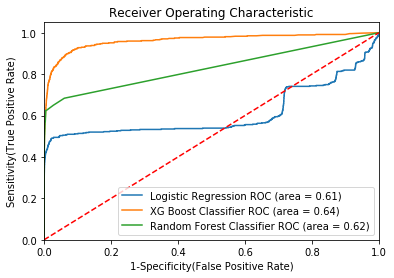

In [86]:
y_raw = df['high_roller_mark']
X_raw = df[['gw_7_days','egw_7_days','bet_7_days','number_of_bets_7_days','number_of_games_7_days']]

x_train, x_test, y_train, y_test = train_test_split( X_raw, y_raw, test_size=0.3, random_state=0)


plt.figure()

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(),
},
{
    'label':'XG Boost Classifier',
    'model':XGBClassifier(max_depth = 8),
},
{
    'label':'Random Forest Classifier',
    'model':RandomForestClassifier(max_depth = 3, n_estimators = 5),
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(x_train, y_train) # train the model
    y_pred=model.predict(x_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(x_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(x_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

### Normalizaed data

<Figure size 432x288 with 0 Axes>

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

(0.0, 1.0)

(0.0, 1.05)

Text(0.5,0,'1-Specificity(False Positive Rate)')

Text(0,0.5,'Sensitivity(True Positive Rate)')

Text(0.5,1,'Receiver Operating Characteristic')

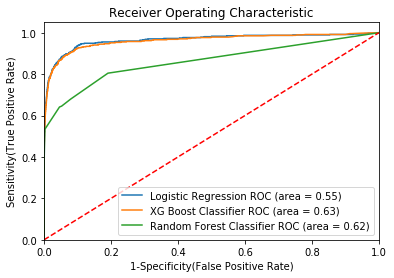

In [87]:
y_raw = df['high_roller_mark']
X_raw = scaled_df[['gw_7_days','egw_7_days','bet_7_days','number_of_bets_7_days','number_of_games_7_days']]

x_train, x_test, y_train, y_test = train_test_split( X_raw, y_raw, test_size=0.3, random_state=0)


plt.figure()

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(),
},
{
    'label':'XG Boost Classifier',
    'model':XGBClassifier(max_depth = 8),
},
{
    'label':'Random Forest Classifier',
    'model':RandomForestClassifier(max_depth = 3, n_estimators = 5),
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(x_train, y_train) # train the model
    y_pred=model.predict(x_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(x_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(x_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show() 

### Tranformed data

<Figure size 432x288 with 0 Axes>

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

(0.0, 1.0)

(0.0, 1.05)

Text(0.5,0,'1-Specificity(False Positive Rate)')

Text(0,0.5,'Sensitivity(True Positive Rate)')

Text(0.5,1,'Receiver Operating Characteristic')

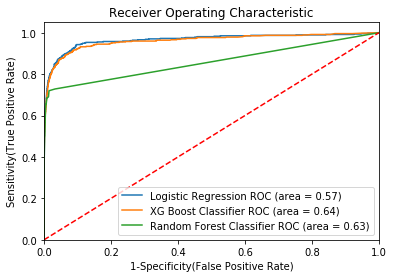

In [88]:
y_raw = df['high_roller_mark']
X_raw = transformet_df[['gw_7_days','egw_7_days','bet_7_days','number_of_bets_7_days','number_of_games_7_days']]

x_train, x_test, y_train, y_test = train_test_split( X_raw, y_raw, test_size=0.3, random_state=0)


plt.figure()

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(),
},
{
    'label':'XG Boost Classifier',
    'model':XGBClassifier(max_depth = 8),
},
{
    'label':'Random Forest Classifier',
    'model':RandomForestClassifier(max_depth = 3, n_estimators = 5),
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(x_train, y_train) # train the model
    y_pred=model.predict(x_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(x_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(x_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show() 

### Balansed data

<Figure size 432x288 with 0 Axes>

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

(0.0, 1.0)

(0.0, 1.05)

Text(0.5,0,'1-Specificity(False Positive Rate)')

Text(0,0.5,'Sensitivity(True Positive Rate)')

Text(0.5,1,'Receiver Operating Characteristic')

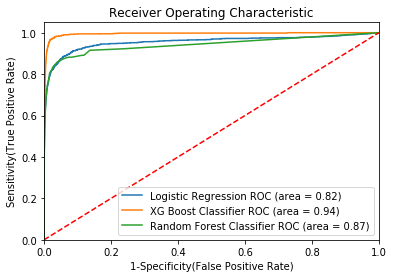

In [89]:
y_raw = balanced_df['high_roller_mark']
X_raw = balanced_df[['gw_7_days','egw_7_days','bet_7_days','number_of_bets_7_days','number_of_games_7_days']]

x_train, x_test, y_train, y_test = train_test_split( X_raw, y_raw, test_size=0.3, random_state=0)


plt.figure()

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(),
},
{
    'label':'XG Boost Classifier',
    'model':XGBClassifier(max_depth = 8),
},
{
    'label':'Random Forest Classifier',
    'model':RandomForestClassifier(max_depth = 3, n_estimators = 5),
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(x_train, y_train) # train the model
    y_pred=model.predict(x_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(x_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(x_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show() 